In [2]:
import numpy as np

In [507]:
# next free


In [508]:
closest_neighbors = np.array([[1,2], [2,0], [1,0], [4,5],[5,3],[3,4]], dtype=np.int64)

In [509]:
np.random.seed(2)
forest2(closest_neighbors)

([array([1, 2, 0]), array([3, 5, 4])],
 array([[2, 1],
        [5, 3],
        [0, 1],
        [4, 5]]))

In [510]:
np.random.seed(1)
forest(closest_neighbors)

(array([0, 0, 0, 1, 1, 1]),
 ListType[array(int64, 1d, C)]([[2 1 0], [4 5 3], ...]),
 array([[2, 1],
        [1, 0],
        [4, 5],
        [5, 3]]))

In [511]:
from numba import njit
from numba.types import int16, int32, int64

In [512]:
@njit([(int16[:], int32), (int32[:], int32), (int64[:], int64)],cache=True)
def my_bincount(arr, min_lenght):
    """The same as numpy bincount, but works on unsigned integers as well"""
    if min_lenght <= 0:
        m=arr.max() # pragma: no cover
    else:
        m = min_lenght
    out = np.zeros(m+1, dtype=arr.dtype)
    for i in range(len(arr)):
        out[arr[i]]+=np.int32(1)
    return out

In [609]:
def filter_edges(edges, keep_nodes):
    out_edges = np.empty_like(edges)
    n = 0
    for i in range(edges.shape[0]):
        l = edges[i,0]
        r = edges[i,1]
        if l in keep_nodes and r in keep_nodes:
            out_edges[n,0]=l
            out_edges[n,1]=r
            n+=1
    return out_edges[:n,:]

In [763]:

def split_component(steiners, component, k, start_pos, neighbors, messages_still_pending, sub_tree_size):
    component = np.random.permutation(component)
    # print(component)
    s = len(component) - len(steiners)
    l = list()

    if s <= max(2*k-1, 3*k-5):
        l.append((steiners, component))
        return l
    steiners1 = steiners.copy()
    steiners2 = steiners.copy()
    for i, pivot in enumerate(component):
        degree_pivot = start_pos[pivot+1]-start_pos[pivot]
        if pivot in steiners:
            continue
        if degree_pivot==1:
            continue
        sub_tree_sizes = hang_tree(pivot, component, start_pos, neighbors, messages_still_pending, sub_tree_size, steiners)
        j = np.argmax(sub_tree_sizes[:,1])
        v = sub_tree_sizes[j,0]
        phi = sub_tree_sizes[j,1]
        #print("phi", pivot, phi)
        # print(sub_tree_sizes)
        if s-phi < k-1:
            continue
        if phi>=k and s-phi >=k:
            comp1 = find_subtree(pivot, v, start_pos, neighbors, sub_tree_size, component)
            comp2 = find_subtree(v, pivot, start_pos, neighbors, sub_tree_size, component)
            l.append((steiners1, comp1))
            l.append((steiners2, comp2))
            # print("A", pivot, list(l))
            return l
        elif s-phi == k-1:
            if v in steiners:
                continue
            comp1_p = find_subtree(pivot, v, start_pos, neighbors, sub_tree_size, component)
            # print("B1", comp1_p)
            comp1 = np.empty(len(comp1_p)+1, dtype=comp1_p.dtype)
            comp1[0]=v
            comp1[1:]=comp1_p[:]
            comp2 = find_subtree(v, pivot, start_pos, neighbors, sub_tree_size, component)
            # print("B", v, pivot, comp1, comp2)
            steiners2.append(v)
            l.append((steiners1, comp1))
            l.append((steiners2, comp2))
            #print("B", pivot, v, list(l))
            return l
        elif s-phi == k-1:
            comp1 = find_subtree(pivot, v, start_pos, neighbors, sub_tree_size, component)
            comp2 = find_subtree(v, pivot, start_pos, neighbors, sub_tree_size, component)
            comp2_p = np.empty(len(comp2)+1, dtype=comp1.dtype)
            comp2[0]=pivot
            comp2[1:]=comp2_p
            steiners2.append(v)
            l.append((steiners1, comp1))
            l.append((steiners2, comp2))
            # print("C", pivot, list(l))
            return l
        else:
            # print("D", pivot, list(l))
            num_subtrees = sub_tree_sizes.shape[0]
            order = np.random.permutation(num_subtrees)
            i_order = 0
            tree_size = 0
            while tree_size < k-1:
                tree_size+=sub_tree_sizes[order[i_order],1]
                i_order+=1
            #print(sub_tree_sizes)
            #print(tree_size)
            add_pivot_to_1 = True
            if s-tree_size == k-1:
                add_pivot_to_1=False
            else:
                add_pivot_to_1=True
            comp1 = np.empty(tree_size+1, dtype=np.int64)
            comp2 = np.empty(s-tree_size+1, dtype=np.int64)
            comp1[0]=pivot
            comp2[0]=pivot
            i_comp1 = 1
            i_comp2 = 1
            if add_pivot_to_1:
                steiners2.append(pivot) # the pivot is assigned to comp1, thus 2 is steiner
            else:
                steiners1.append(pivot)
            
            for j in range(num_subtrees):
                sub_node = sub_tree_sizes[order[j],0]
                comp_tmp = find_subtree(sub_node, pivot, start_pos, neighbors, sub_tree_size, component)
                #print(j, sub_node, comp_tmp)
                for sub_tree_member in comp_tmp:
                    if j < i_order:
                        comp1[i_comp1] = sub_tree_member
                        i_comp1+=1
                    else:
                        comp2[i_comp2] = sub_tree_member
                        i_comp2+=1
            l.append((steiners1, comp1))
            l.append((steiners2, comp2))
            return l
        # l1 = split_component(steiners1, comp1, k, start_pos, neighbors, messages_still_pending, sub_tree_size, component)
        # l.extend(l1)    
        # l2 = split_component(steiners2, comp2, k, start_pos, neighbors, messages_still_pending, sub_tree_size, component)
        # l.extend(l2)
        
        return l
    assert False  
        

In [764]:

 def hang_tree(pivot, nodes, start_pos, neighbors, messages_still_pending, sub_tree_size, steiners):
    # print()
    degree_pivot = start_pos[pivot+1]-start_pos[pivot]
    out = np.empty((degree_pivot, 2), dtype=np.int64)
    num_out=0
    leaves = np.empty_like(nodes)
    num_leaves=0

    # Fill initial leaves
    for node in nodes:
        if node not in steiners:
            sub_tree_size[node] = 1
        else:
            sub_tree_size[node] = 0
        degree_node = start_pos[node+1]-start_pos[node]
        if degree_node!=1:
            continue
        leaves[num_leaves]=node
        num_leaves+=1
        messages_still_pending[node]=0 # leaf nodes need no messages
    # print("pivot", pivot)
    # print(messages_still_pending)
    while num_leaves > 0:
        # pop node from the queue
        num_leaves -=1
        node = leaves[num_leaves]
        # print("node", node)
        if node == pivot: # pivot never needs to send messages
            continue
        # propagate to neighbors
        start = start_pos[node]
        stop = start_pos[node+1]
        # print(node, start, stop, neighbors[start:stop], len(neighbors))
        for neigh in neighbors[start:stop]:
            if messages_still_pending[neigh]<=1:
                continue
            # print("  ", node, neigh)
            sub_tree_size[neigh]+=sub_tree_size[node]
            
            if neigh == pivot:
                out[num_out,0]=node
                out[num_out,1]=sub_tree_size[node]
                num_out+=1
                #print("root", node)
                break
            if messages_still_pending[neigh]>2:
                messages_still_pending[neigh]-=1
            elif messages_still_pending[neigh]==2: # this node is now a leaf so enqueu
                messages_still_pending[neigh]-=1
                # print(node, neigh, sub_tree_size[node], sub_tree_size[neigh])
                
                leaves[num_leaves] = neigh
                num_leaves+=1
                # print("new_leaf", neigh)
            break
    #print(messages_still_pending, pivot)
    # reset global arrays
    for node in nodes:
        degree = start_pos[node+1]-start_pos[node]
        messages_still_pending[node]=degree
        sub_tree_size[node]=0
    assert num_out == degree_pivot, (pivot, num_out, degree_pivot)
    return out       

In [765]:
from itertools import chain

In [766]:
seed = 25
np.random.seed(seed)
result = decompose_components(components, edges, 3, len(df))
print(result)
for steiner, comp in result:
    print(list(map(int, steiner)), list(map(int, comp)))
for steiner, comp in result:
    assert len(set(comp)-set(steiner))>=3, seed
comps = [comp for steiner, comp in result]
assert len(set(chain.from_iterable(comps)))==11 
if len(result)>2:
    print(seed)
    for steiner, comp in result:
        print(list(map(int, steiner)), list(map(int, comp)))

[([], array([ 5,  8, 10])), ([np.int64(5)], array([1, 9, 0])), ([np.int64(5), np.int64(1)], array([1, 2, 3, 5, 7, 6, 4]))]
[] [5, 8, 10]
[5] [1, 9, 0]
[5, 1] [1, 2, 3, 5, 7, 6, 4]
25
[] [5, 8, 10]
[5] [1, 9, 0]
[5, 1] [1, 2, 3, 5, 7, 6, 4]


In [767]:
target_result = set([frozenset([0,9,1]), frozenset([2,3,4]), frozenset([6,7,5,8,10])])

In [768]:
for seed in tqdm(range(1_000_000)):
    np.random.seed(seed)
    result = decompose_components(components, edges, 3, len(df))
    for steiner, comp in result:
        assert len(set(comp)-set(steiner))>=3, seed
    comps = [comp for steiner, comp in result]
    assert len(set(chain.from_iterable(comps)))==11
    if len(result)>1000:
        this_set = set()
        for steiner, comp in result:
            this_set.add(frozenset(list(map(int, comp))))
        if target_result == this_set:
            print(seed)
            for steiner, comp in result:
                print(list(map(int, steiner)), list(map(int, comp)))
            break

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [554]:
for seed in tqdm(range(10)):
    np.random.seed(seed)
    result = decompose_components(components, edges, 3, len(df))
    for steiner, comp in result:
        print(list(map(int, steiner)), list(map(int, comp)))
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

[] [1, 9, 0]
[] [2, 3, 5, 7, 8, 10, 6, 4]

[] [2, 3, 1, 9, 0, 4]
[] [5, 7, 8, 10, 6]

[] [1, 9, 0]
[] [2, 3, 5, 7, 8, 10, 6, 4]

[] [1, 9, 0]
[1] [1, 2, 3, 5, 7, 8, 10, 6, 4]

[] [5, 7, 8, 10, 6]
[] [2, 3, 1, 9, 0, 4]

[] [1, 9, 0]
[1] [1, 2, 3, 5, 7, 8, 10, 6, 4]

[] [2, 3, 4]
[2] [2, 5, 1, 9, 0, 7, 8, 10, 6]

[] [1, 9, 0]
[1] [1, 2, 3, 5, 7, 8, 10, 6, 4]

[] [5, 7, 6]
[5] [5, 2, 8, 10, 3, 1, 9, 0, 4]

[] [5, 7, 6]
[5] [5, 2, 8, 10, 3, 1, 9, 0, 4]



In [499]:
records = [
["A&A Ltd " ,790 ,55 ,3212334 ,313250],
["B&B SpA " ,710 ,44 ,2283340 ,299876],
["C&C Inc " ,730 ,32 ,1989233 ,200213],
["D&D BV  " ,810 ,17 ,984983  ,143211],
["E&E SL  " ,950 ,3  ,194232  ,51233],
["F&F GmbH" ,510 ,25 ,119332  ,20333],
["G&G AG  " ,400 ,45 ,3012444 ,501233],
["H&H SA  " ,330 ,50 ,4233312 ,777882],
["I&I LLC " ,510 ,5  ,159999  ,60388 ],
["J&J Co  " ,760 ,52 ,5333442 ,1001233],
["K&K Sarl" ,50  ,12 ,645223  ,333010],]

In [348]:
import pandas as pd

In [349]:
df = pd.DataFrame.from_records(records, columns=["name", "surface", "employees", "turnover", "profit"])

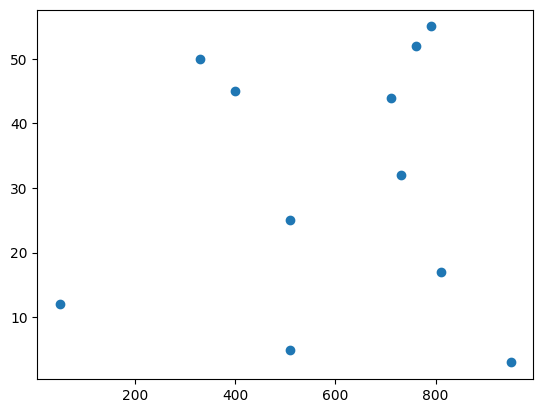

In [231]:
import matplotlib.pyplot as plt
plt.scatter(df.surface, df.employees)

In [232]:
def permutate_closest_neighbors(closest_neighbors):
    k = closest_neighbors.shape[1]
    for i in range(closest_neighbors.shape[0]):
        closest_neighbors[i,:]=closest_neighbors[i,:][np.random.permutation(k)]

In [308]:
def apply_basic(df, k):
    if isinstance(df, pd.DataFrame):
        arr = df.to_numpy()
    else:
        arr = df
    # print(arr)
    dists = compute_dists(arr)
    # print(dists)
    closest_neighbors = get_k_closest(dists, k)
    permutate_closest_neighbors(closest_neighbors)
    # print(closest_neighbors)
    components, edges = forest2(closest_neighbors)
    return components, edges

In [309]:
@njit(cache=True)
def _set_seed(seed):
    """Set the need. This needs to be done within numba @njit function"""
    np.random.seed(seed)

In [310]:
from tqdm.notebook import tqdm

In [323]:
from sklearn import preprocessing
df_in = preprocessing.StandardScaler().fit_transform(df[[ "surface", "employees"]])
# df_in = df[[ "surface", "employees"]]
for seed in tqdm(range(300_000, 1_000_000)):
    np.random.seed(seed)
    _set_seed(seed)
    components, edges = apply_basic(df_in, 3)
    s = set(map(tuple, edges))
    if all(x in s for x in [(6,7), (3,4), (2,3), (8,5), (10,8), (7,5), (5,2), (1,2)]):
        print(seed)
        print(edges)
        break

  0%|          | 0/700000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [298]:
df_in = preprocessing.StandardScaler().fit_transform(df[[ "surface", "employees"]])
pos = {}
for i in range(len(df)):
    pos[i] = (df_in[i,0], df_in[i,1])
print(pos)

{0: (np.float64(0.7775189605962344), np.float64(1.296684835461171)), 1: (np.float64(0.4577915375473155), np.float64(0.7046136464392778)), 2: (np.float64(0.5377233933095452), np.float64(0.05871780386993977)), 3: (np.float64(0.8574508163584641), np.float64(-0.7486519993417329)), 4: (np.float64(1.416973806694072), np.float64(-1.5021971490059607)), 5: (np.float64(-0.34152702007498165), np.float64(-0.3180547709621741)), 6: (np.float64(-0.781152226767245), np.float64(0.7584382999867227)), 7: (np.float64(-1.060913721935049), np.float64(1.027561567723947)), 8: (np.float64(-0.34152702007498165), np.float64(-1.3945478419110708)), 9: (np.float64(0.6576211769528898), np.float64(1.1352108748188365)), 10: (np.float64(-2.179959702606265), np.float64(-1.017775267078957))}


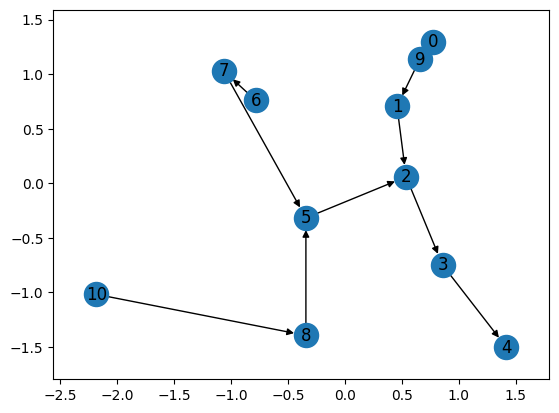

In [328]:
import networkx as nx

seed=373152 # magical seed that procudes the example in the paper :)
np.random.seed(seed)
_set_seed(seed)
components, edges = apply_basic(df_in, 3)

G = nx.DiGraph()
G.add_nodes_from(df.index)
G.add_edges_from(edges)
plt.figure()
nx.draw_networkx(G, pos = pos, hide_ticks=False)
plt.scatter(df_in[:,0], df_in[:,1])
plt.draw()

NameError: name 'degrees' is not defined